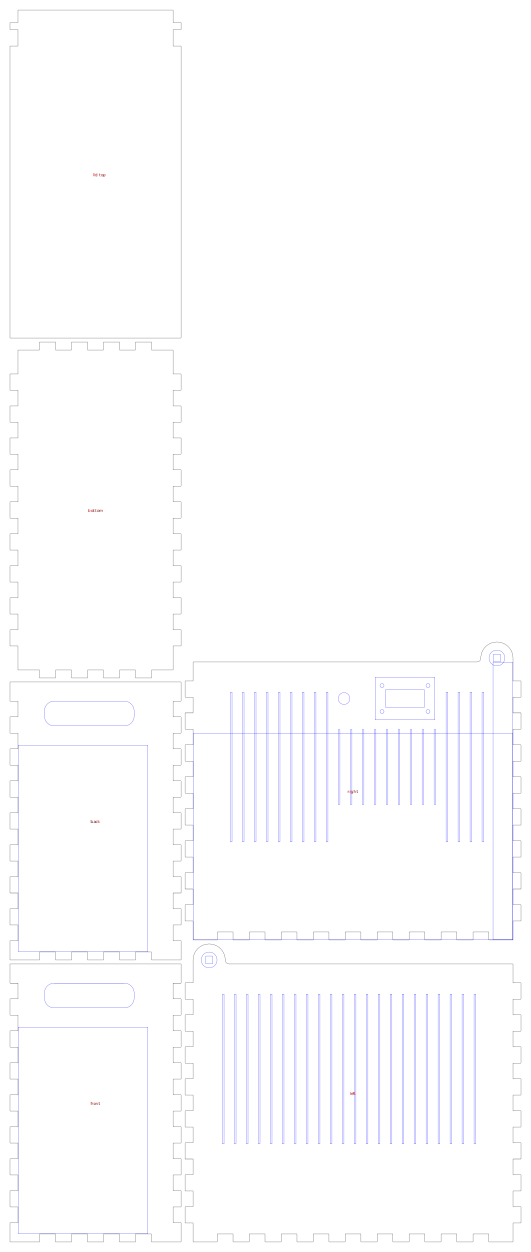

In [5]:
from IPython.display import SVG, display

import sys
sys.path.append('..') # uncomments and adjust if your Boxes.py copy in not in the Python path
from boxes import *
from boxes import lids
from boxes.edges import Bolts
from boxes.lids import _TopEdge


class MyUniversalBox(_TopEdge):
    """Box with various options for different styles and lids"""

    ui_group = "Box"

    def __init__(self) -> None:
        Boxes.__init__(self)
        self.addTopEdgeSettings(roundedtriangle={"outset" : 1},
                                hinge={"outset" : True})
        self.addSettingsArgs(edges.FlexSettings)
        self.addSettingsArgs(lids.LidSettings)
        self.buildArgParser("top_edge", "bottom_edge",
                            "x", "y", "h", "outside")
        self.argparser.add_argument(
            "--vertical_edges",  action="store", type=str,
            default="finger joints",
            choices=("finger joints", "finger holes"),
            help="connections used for the vertical edges")

    def rect_holes(self, right=False):
        w, h_full = 2, 150
        y = Z / 2 + 30
        for i in range(22):
            x = 30 + (w + 10) * i
            h = h_full
            if right:
                if x > anderson_x_start - 10 and x < max(anderson_x_start + anderson_x, power_button_x + power_button_d):
                    h = h_full / 2
                x = self.y - x
            self.rectangularHole(x, y, w, h, center_y=True)
    
    def top_hole(self, x, y, top_edge):
        t = self.thickness

        if top_edge == "f":
            edge = self.edges["F"]
            self.moveTo(2*t+self.burn, 2*t, 90)
        elif top_edge == "F":
            edge = self.edges["f"]
            self.moveTo(t+self.burn, 2*t, 90)
        else:
            raise ValueError("Only f and F supported")

        for l in (y, x, y, x):
            edge(l)
            if top_edge == "F": self.edge(t)
            self.corner(-90)
            if top_edge == "F": self.edge(t)

    def anderson_mounting_holes(self):
        x0 = anderson_x_start
        y0 = Z - anderson_pad_top - anderson_h + (anderson_h - anderson_y) / 2
        for i in range(2):
            for j in range(2):
                self.hole(y0 + j * anderson_y, x0 + i*anderson_x, M4_d / 2)
        x_center, y_center = x0 + anderson_x / 2, y0 + anderson_y / 2
        self.rectangularHole(y_center, x_center, 18, 39, center_x=True, center_y=True)
        self.hole(y0 + anderson_y / 2, power_button_x, power_button_d / 2)
        if draw_debug:
            self.rectangularHole(y_center, x_center, anderson_h, anderson_w, center_x=True, center_y=True)
            self.rectangularHole(0, 0, Z_batt, Y, center_x=False, center_y=False)
            self.rectangularHole(0, 0, Z + thickness, thickness * 2.5, center_x=False, center_y=False)

    def draw_handle(self):
        self.rectangularHole(X / 2 - (X - X_batt) / 4, Z_batt + (Z - Z_batt) / 2, handle_x, handle_y, handle_r, center_y=True, center_x=True)
        if draw_debug:
            self.rectangularHole(0, 0, X_batt, Z_batt, center_x=False, center_y=False)
    
    def render(self):
        x, y, h = self.x, self.y, self.h
        t = self.thickness

        tl, tb, tr, tf = self.topEdges(self.top_edge)
        b = self.edges.get(self.bottom_edge, self.edges["F"])

        d2 = Bolts(2)
        d3 = Bolts(3)

        d2 = d3 = None

        sideedge = "F" if self.vertical_edges == "finger joints" else "h"

        if self.outside:
            self.x = x = self.adjustSize(x, sideedge, sideedge)
            self.y = y = self.adjustSize(y)
            self.h = h = self.adjustSize(h, b, self.top_edge)

        with self.saved_context():
            self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="front", callback=[self.draw_handle])
            self.rectangularWall(x, h, [b, sideedge, tb, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="back", callback=[self.draw_handle])

            if self.bottom_edge != "e":
                self.rectangularWall(x, y, "ffff", bedBolts=[d2, d3, d2, d3], move="up", label="bottom", callback=[])
            if self.top_edge in "fF":
                self.set_source_color(Color.MAGENTA)    # I don't know why this part has a different color, but RED is not a good choice because RED is used for annotations
                self.rectangularWall(x+4*t, y+4*t, callback=[
                    lambda:self.top_hole(x, y, self.top_edge)], move="up", label="top hole")
                self.set_source_color(Color.BLACK)
            self.drawLid(x, y, self.top_edge, [d2, d3])
            self.lid(x, y, self.top_edge)

        self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                             ignore_widths=[1, 6],
                             bedBolts=[d2], move="right only", label="invisible")
        self.rectangularWall(y, h, [b, "f", tl, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="left", callback=[lambda: self.rect_holes(False)])
        self.rectangularWall(y, h, [b, "f", tr, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="right", callback=[lambda: self.rect_holes(True), self.anderson_mounting_holes])

thickness = 8.0
Y = 300 + thickness * 2.5
X = 155
Z = 270

X_batt = 130
Z_batt = 207

anderson_pad_top = 7
anderson_w = 60
anderson_h = 43
anderson_x = 46
anderson_y = 26
anderson_x_start = 85
M4_d = 4.2

power_button_d = 12.0
power_button_x = anderson_x_start + anderson_w + 2 * power_button_d

handle_x = 90
handle_y = 25
handle_r = 10

draw_debug = True

b = MyUniversalBox()
b.parseArgs(['--reference=0', '--debug=0', f'--thickness={thickness}', '--top_edge=i', '--bottom_edge=F', f'--x={X}', f'--y={Y}', f'--h={Z}', '--outside=0', '--Hinge_style=flush'])
#b.parseArgs()
b.open()
b.render()
data = b.close()

with open('boxes_battery_pack.svg', "wb") as f:
    f.write(data.getbuffer())

display(SVG(data=data.getvalue()))